In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
# Clone EasyOCR repo (has CRAFT trainer)
!git clone https://github.com/JaidedAI/EasyOCR.git
%cd EasyOCR

# Install Python dependencies
!pip install -r trainer/craft/requirements.txt
!pip install scikit-image # for `io.imread`



Cloning into 'EasyOCR'...
remote: Enumerating objects: 2750, done.
remote: Counting objects: 100% (869/869), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 2750 (delta 790), reused 763 (delta 763), pack-reused 1881 (from 1)
Receiving objects: 100% (2750/2750), 157.82 MiB | 30.07 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
Updating files: 100% (313/313), done.
/content/EasyOCR
ERROR: Ignored the following yanked versions: 3.0.6, 3.5.0, 3.7.0, 3.17.0, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.0.4, 4.0.5, 4.0.7, 4.0.8, 4.0.9, 4.1.2, 4.1.6, 4.2.6, 4.2.7, 4.3.13, 4.3.16
ERROR: Could not find a version that satisfies the requirement conda==4.10.3 (from versions: none)
ERROR: No matching distribution found for conda==4.10.3


In [3]:
%cd /content/EasyOCR/trainer/craft/


/content/EasyOCR/trainer/craft


In [4]:
# Set up import paths
import sys
sys.path.append('/content/EasyOCR/trainer/craft/utils')
sys.path.append('/content/EasyOCR/trainer/craft/data')
sys.path.append('/content/EasyOCR/trainer/craft/model')

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

from craft import CRAFT

from craft_utils import getDetBoxes, adjustResultCoordinates
from imgproc import loadImage, resize_aspect_ratio, normalizeMeanVariance
print("CRAFT utils and imgproc loaded successfully.")


CRAFT utils and imgproc loaded successfully.


In [7]:
import torch
from collections import OrderedDict

def copyStateDict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith("module") else k
        new_state_dict[name] = v
    return new_state_dict

def load_craft_model(path, use_cuda=False):
    net = CRAFT()
    checkpoint = torch.load(path, map_location='cpu')
    net.load_state_dict(copyStateDict(checkpoint['craft']))  #  not the whole checkpoint!
    net.eval()
    if use_cuda:
        net = net.cuda()
    return net

# Try loading
craft_model = load_craft_model('/content/drive/MyDrive/models/CRAFT_clr_amp_14000(1).pth', use_cuda=False)
print("CRAFT model loaded ")


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 234MB/s]


CRAFT model loaded 


In [8]:
from ultralytics import YOLO
import torch
from craft_utils import getDetBoxes, adjustResultCoordinates
from imgproc import loadImage, resize_aspect_ratio, normalizeMeanVariance

# Load your models
human_detector = YOLO('/content/drive/MyDrive/models/human_detector_yolov8.pt')
bib_detector = YOLO('/content/drive/MyDrive/models/number_detector_yolov8n.pt')



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
import cv2
def detect_humans_yolo(image):
    results = human_detector.predict(image)
    boxes = []
    for r in results:
        for box, cls_id in zip(r.boxes.xyxy, r.boxes.cls):
            if r.names[int(cls_id)] == 'person':
                boxes.append(box.cpu().numpy())
    return boxes

In [10]:
def crop_torso(image, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    w = x2 - x1
    h = y2 - y1
    torso_top = y1 + h // 3
    torso_bottom = y1 + (2 * h) // 3
    torso_top = max(0, torso_top)
    torso_bottom = min(image.shape[0], torso_bottom)
    return image[torso_top:torso_bottom, x1:x2]


In [11]:

def run_craft_on_crop(craft_model, crop_img, canvas_size=1280, mag_ratio=1.5,
                      text_threshold=0.7, link_threshold=0.4, low_text=0.4, use_cuda=False):

    img_resized, target_ratio, size_heatmap = resize_aspect_ratio(
        crop_img, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    x = normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0).float()

    if use_cuda:
        x = x.cuda()

    with torch.no_grad():
        y, _ = craft_model(x)

    score_text = y[0, :, :, 0].cpu().numpy()
    score_link = y[0, :, :, 1].cpu().numpy()

    boxes, _ = getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text)
    boxes = adjustResultCoordinates(boxes, ratio_w, ratio_h)

    return boxes


In [22]:
def run_bib_number_detection(model, torso_crop, conf_thresh=0.25):
    results = model.predict(torso_crop, conf=conf_thresh)

    # Extract predictions
    boxes = []
    for r in results:
        for b in r.boxes.xyxy.cpu().numpy():
            boxes.append(b.astype(int))  # [x1, y1, x2, y2]

    return boxes

def visualize_bib_boxes(image, boxes, color=(255, 0, 0)):
    img_copy = image.copy()

    for box in boxes:
        # Ensure box is (4, 2)
        box = np.array(box).reshape(-1, 2)

        # Get bounding rect
        x_coords = box[:, 0]
        y_coords = box[:, 1]
        x1, y1 = int(x_coords.min()), int(y_coords.min())
        x2, y2 = int(x_coords.max()), int(y_coords.max())

        # Draw rectangle
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)

    return img_copy



In [13]:
def sort_boxes_left_to_right(boxes):
    return sorted(boxes, key=lambda box: box[0])  # sort by x1


def extract_bib_number(model, image, conf=0.25):
    results = model.predict(image, conf=conf)[0]

    digits = []
    for box, cls in zip(results.boxes.xyxy, results.boxes.cls):
        x1, y1, x2, y2 = map(int, box.cpu().numpy())
        digit = int(cls.cpu().numpy())
        digits.append((x1, digit))  # we store x1 to sort later

    # Sort digits left to right
    digits.sort(key=lambda x: x[0])
    bib_number = ''.join([str(d) for _, d in digits])

    return bib_number


In [20]:
import matplotlib.pyplot as plt
import cv2

def run_pipeline_on_image(image_path, visualize=False):
    image = loadImage(image_path)
    results = human_detector(image)
    persons = results[0].boxes.xyxy.cpu().numpy()

    for i, person_box in enumerate(persons):
        torso = crop_torso(image, person_box)
        craft_boxes = run_craft_on_crop(craft_model, torso)

        if len(craft_boxes) > 0:
            bib_number = extract_bib_number(bib_detector, torso)
            print(f"[✓] Image: {image_path} | Bib Number: {bib_number}")

            # Optional visualization
            if visualize:
                img_with_boxes = visualize_bib_boxes(torso, craft_boxes)
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
                plt.title(f"Bibs for Human #{i+1}")
                plt.axis("off")
                plt.show()

            return torso, craft_boxes  # return for further use if needed
        else:
            print(f"[!] No text detected for human #{i+1} in image.")

    return None, None


In [24]:
import numpy as np


0: 448x640 4 persons, 6.7ms
Speed: 3.0ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
[!] No text detected for human #1 in image.

0: 512x640 1 0, 1 3, 1 4, 1 5, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)
[✓] Image: /content/img.jpg | Bib Number: 3045


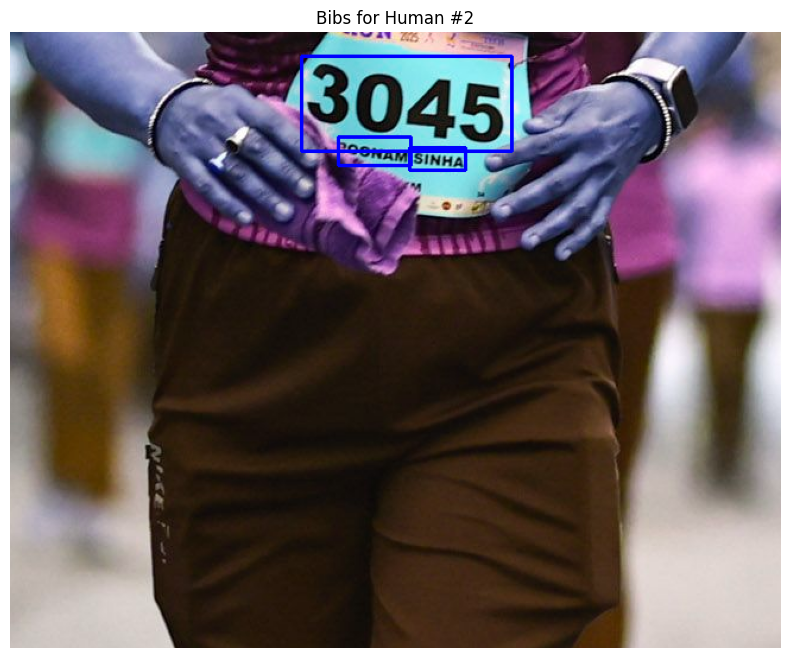

In [25]:
torso_crop, boxes = run_pipeline_on_image("/content/img.jpg", visualize=True)
